# **Common Test I. Multi-Class Classification**
I have used ResNet50 model and unfreezed its last block for training which is followed by flattening and dene layers. Later on ROC plot is presented. Due to contrained time I was not able to optimize the hyperparameters but my notebook gave the correct order to rackle such problem.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc
import os

In [3]:

# Custom Dataset Class with Data Augmentation
class LensDataset(Dataset):
    def __init__(self, data_dir, split, transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.images, self.labels = self.load_data()
        self.transform = transform

    def load_data(self):
        images, labels = [], []
        classes = ['no', 'sphere', 'vort']
        for idx, label in enumerate(classes):
            folder_path = os.path.join(self.data_dir, label)
            for file in os.listdir(folder_path):
                if file.endswith(".npy"):
                    img = np.load(os.path.join(folder_path, file))
                    img = torch.tensor(img, dtype=torch.float32)  # Ensure 1-channel
                    images.append(img)
                    labels.append(idx)
        return images, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)  # Apply Data Augmentation
        return img, label

In [4]:
# Define Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])


# Load Dataset
data_dir = "/content/drive/MyDrive/GSC/GSOC/Common Test I. Multi-Class Classification dataset/dataset"
train_dataset = LensDataset(data_dir, split="train" , transform=train_transform)
val_dataset = LensDataset(data_dir, split="val")


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [7]:
import torch.nn as nn
import torchvision.models as models

class LensClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(LensClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)

        # Modify first layer for 1-channel input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze all layers first
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze only the last block (layer4) and the fully connected (fc) layer
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        for param in self.model.fc.parameters():
            param.requires_grad = True

        # Modify the final classification layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize Model
model = LensClassifier(num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)




In [8]:
# Training Function without Validation During Training
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=30, save_path="best_model.pth"):
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Reduce LR based on training loss
        scheduler.step(train_loss)

        # Save best model based on training loss
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model Saved with Training Loss: {train_loss:.4f}")

    print("\n Training Complete! Now running validation...")

# Evaluation Function (Only Run After Training Ends)
def evaluate_model(model, val_loader):
    model.eval()
    total, correct = 0, 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    print(f" Validation Done! Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

# Train the Model
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=30)

# Load Best Model & Validate
model.load_state_dict(torch.load("best_model.pth"))
evaluate_model(model, val_loader)


<ipython-input-8-8b33cef9a031>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)


Epoch 1/30, Train Loss: 1.1174
✅ Model Saved with Training Loss: 1.1174
Epoch 2/30, Train Loss: 1.1001
✅ Model Saved with Training Loss: 1.1001
Epoch 3/30, Train Loss: 1.0944
✅ Model Saved with Training Loss: 1.0944
Epoch 4/30, Train Loss: 1.0905
✅ Model Saved with Training Loss: 1.0905
Epoch 5/30, Train Loss: 1.0871
✅ Model Saved with Training Loss: 1.0871
Epoch 6/30, Train Loss: 1.0820
✅ Model Saved with Training Loss: 1.0820
Epoch 7/30, Train Loss: 1.0782
✅ Model Saved with Training Loss: 1.0782
Epoch 8/30, Train Loss: 1.0744
✅ Model Saved with Training Loss: 1.0744
Epoch 9/30, Train Loss: 1.0749
Epoch 10/30, Train Loss: 1.0700
✅ Model Saved with Training Loss: 1.0700
Epoch 11/30, Train Loss: 1.0693
✅ Model Saved with Training Loss: 1.0693
Epoch 12/30, Train Loss: 1.0658
✅ Model Saved with Training Loss: 1.0658
Epoch 13/30, Train Loss: 1.0667
Epoch 14/30, Train Loss: 1.0589
✅ Model Saved with Training Loss: 1.0589
Epoch 15/30, Train Loss: 1.0557
✅ Model Saved with Training Loss: 1.0

<ipython-input-8-8b33cef9a031>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)


🛠️ Validation Done! Loss: 1.0410, Accuracy: 0.4409


(1.0409820262421954, 0.44093333333333334)

In [9]:
# Load the Best Model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print("Best model loaded for evaluation!")

✅ Best model loaded for evaluation!


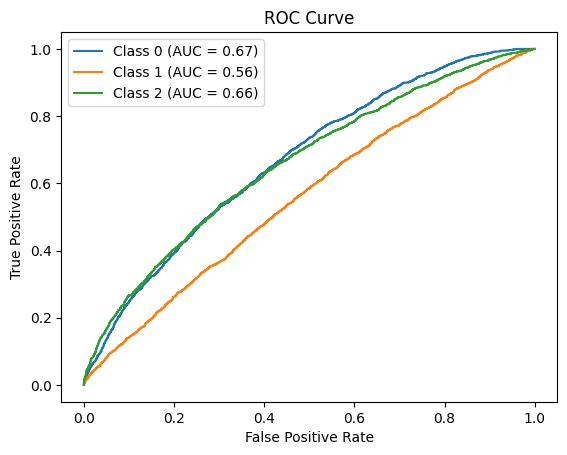

In [10]:
# Compute and Plot ROC Curve
def plot_roc_curve(model, val_loader):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.cpu().numpy()
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_true.extend(labels)
            y_scores.extend(probs)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for i in range(3):  # 3 classes
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Plot ROC Curve
plot_roc_curve(model, val_loader)

In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb